## Install and Import Dependencies

In [1]:
pip install transformers datasets tensorflow scikit-learn numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.8 MB/s eta 0:00:00


In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset

from sklearn.metrics import accuracy_score

## Load Dataset

In [3]:
raw_dataset = load_dataset("imdb")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

#### Split Dataset

In [4]:
train_texts, train_labels = raw_dataset["train"]["text"], raw_dataset["train"]["label"]
test_texts, test_labels = raw_dataset["test"]["text"], raw_dataset["test"]["label"]

## Pretrained BERT without  any Tuning

#### Defining which Model we will use

In [5]:
checkpoint = "bert-base-uncased"

#### Defining Tokenizer

In [6]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

##### Tokenizing our Dataset

In [7]:
def tokenize_data(texts):
    tokens = tokenizer(texts, padding = True, truncation = True, return_tensors = "tf")
    return {
        "input_ids": tokens["input_ids"],
        "attention_mask": tokens["attention_mask"]
    }

test_data = tokenize_data(test_texts)
test_labels = tf.convert_to_tensor(test_labels, dtype = tf.int32)

#### Making Predictions using Pretrained BERT without Tuning

In [8]:
pretrained_bert = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 2)

bert_preds = pretrained_bert.predict(test_data).logits
bert_preds = np.argmax(bert_preds, axis = 1)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


782/782 [==============================] - 1030s 1s/step


#### Evaluation

In [9]:
pretrained_accuracy = accuracy_score(test_labels, bert_preds)
print("Pretrained BERT Accuracy :", pretrained_accuracy)

Pretrained BERT Accuracy : 0.52144


## Pretrained BERT with Fine Tuning

#### Load Pretrained BERT Sequence Classifier

In [10]:
tuned_bert = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
raw_dataset['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

#### Tokenize our Dataset

In [12]:
def tokenize(texts, label):
    tokens = tokenizer(texts, padding = True, truncation = True, return_tensors = "tf")
    return {"input_ids": tokens["input_ids"],
            "attention_mask": tokens["attention_mask"]}, tf.convert_to_tensor(label, dtype = tf.int32)

train_data, train_labels = tokenize(train_texts, train_labels)
test_data, test_labels = tokenize(test_texts, test_labels)

#### Freezing BERT Layers

In [13]:
# Freeze BERT embeddings:
tuned_bert.bert.embeddings.trainable = False
for layer in tuned_bert.bert.encoder.layer:
    layer.trainable = False

In [14]:
for layer in tuned_bert.bert.encoder.layer:
  print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False


#### UnFreezing Last 2 Layers for Fine Tuning

In [15]:
for layers in tuned_bert.bert.encoder.layer[-2:]:
  layers.trainable = True

In [16]:
for layer in tuned_bert.bert.encoder.layer:
  print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
True
True


#### Summary (Trainable and NonTrainable Parameters)

In [17]:
tuned_bert.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 14767874 (56.33 MB)
Non-trainable params: 94715904 (361.31 MB)
_________________________________________________________________


#### Compile Model

In [18]:
tuned_bert.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5),
                   loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                   metrics = ["accuracy"])

#### Model Training

In [19]:
history = tuned_bert.fit(train_data, train_labels,
                         validation_data = (test_data, test_labels),
                         epochs = 3,
                         batch_size = 8)

Epoch 1/3
3125/3125 [==============================] - 2448s 779ms/step - loss: 0.2565 - accuracy: 0.8966 - val_loss: 0.1943 - val_accuracy: 0.9238
Epoch 2/3
3125/3125 [==============================] - 2402s 769ms/step - loss: 0.1995 - accuracy: 0.9235 - val_loss: 0.2304 - val_accuracy: 0.9097
Epoch 3/3
3125/3125 [==============================] - 2401s 768ms/step - loss: 0.1663 - accuracy: 0.9373 - val_loss: 0.1918 - val_accuracy: 0.9262


#### Making Predictions using Fine Tuned BERT

In [20]:
tuned_preds = tuned_bert.predict(test_data).logits
tuned_preds = np.argmax(tuned_preds, axis = 1)

782/782 [==============================] - 1034s 1s/step


#### Save Trained Model and Tokenizers

In [45]:
tuned_bert.save_pretrained('Fine_Tuned_BERT')
tokenizer.save_pretrained('Fine_Tuned_BERT')

('Fine_Tuned_BERT/tokenizer_config.json',
 'Fine_Tuned_BERT/special_tokens_map.json',
 'Fine_Tuned_BERT/vocab.txt',
 'Fine_Tuned_BERT/added_tokens.json',
 'Fine_Tuned_BERT/tokenizer.json')

#### Evaluation

In [22]:
tuned_accuracy = accuracy_score(test_labels, tuned_preds)
print("Fine Tuned BERT Accuracy :", tuned_accuracy)

Fine Tuned BERT Accuracy : 0.9262


##### Visualization

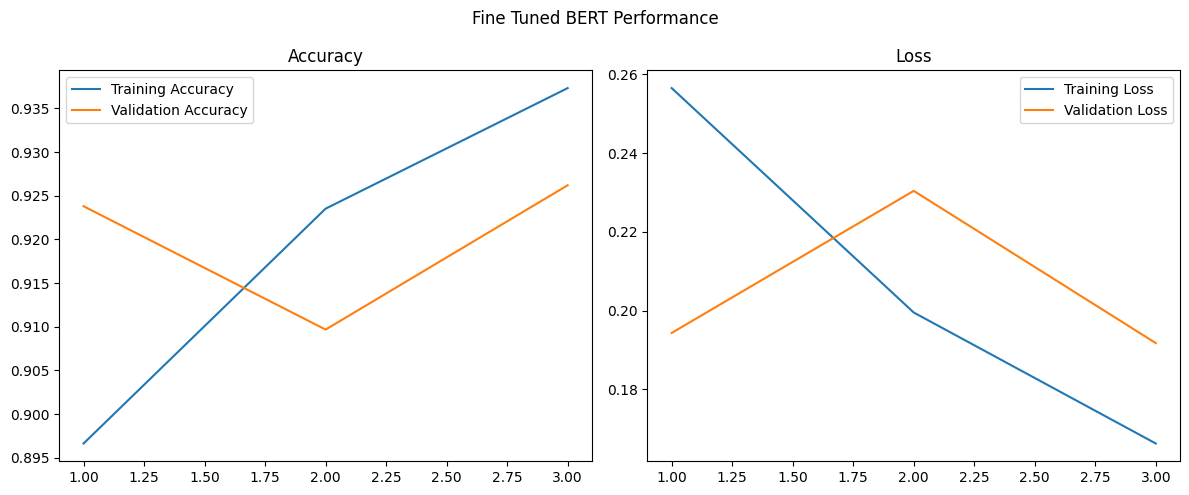

In [42]:
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
sns.lineplot(x = [epoch + 1 for epoch in history.epoch], y = history.history['accuracy'], label = 'Training Accuracy')
sns.lineplot(x = [epoch + 1 for epoch in history.epoch], y = history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title("Accuracy")

plt.subplot(1, 2, 2)
sns.lineplot(x = [epoch + 1 for epoch in history.epoch], y = history.history['loss'], label = 'Training Loss')
sns.lineplot(x = [epoch + 1 for epoch in history.epoch], y = history.history['val_loss'], label = 'Validation Loss')
plt.title("Loss")

plt.suptitle("Fine Tuned BERT Performance")
plt.tight_layout()
plt.show()

## Comparative Analysis

In [24]:
print("BERT Accuracy without Tuning    :", pretrained_accuracy)
print("BERT Accuracy After Fine Tuning :", tuned_accuracy)

BERT Accuracy without Tuning    : 0.52144
BERT Accuracy After Fine Tuning : 0.9262


## Example Uses

In [52]:
model_path = 'Fine_Tuned_BERT'

#### Loading Fine Tuned Model

In [53]:
tuned_bert_user = TFAutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer_user = AutoTokenizer.from_pretrained(model_path)

Some layers from the model checkpoint at Fine_Tuned_BERT were not used when initializing TFBertForSequenceClassification: ['dropout_113']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at Fine_Tuned_BERT.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


#### Sentiment Prediction

In [54]:
def predict_sentiment(text):
    tokens = tokenizer_user(text, padding=True, truncation=True, return_tensors="tf")
    preds = tuned_bert_user.predict(tokens).logits
    pred_class = np.argmax(preds, axis=1)[0]
    return "Positive" if pred_class == 1 else "Negative"

#### Example

In [59]:
text = "This is a fantastic movie!"
sentiment = predict_sentiment(text)
print("Sentiment of '", text, "' :", sentiment)

text = "This movie was terrible."
sentiment = predict_sentiment(text)
print("Sentiment of '", text, "' :", sentiment)

1/1 [==============================] - 0s 63ms/step
Sentiment of ' This is a fantastic movie! ' : Positive
1/1 [==============================] - 0s 70ms/step
Sentiment of ' This movie was terrible. ' : Negative
